# K-Means Clustering
## Clustering temperatures into potentially 'seasons'

<br>

**READ**  -  I've created a python script to allow the user to click the button and then they can either have all of the underyling code shown, OR they can just look at the raw output (charts, plots, whatever).  
As you know, sometimes these notebooks contain a fair amount of code... and sometimes folks just want the _results_... here is an [example](https://nbviewer.jupyter.org/urls/gist.github.com/masnick/d6a1af14812c0c4b3314/raw/f7a5abfb6475e683a90b4ac3491d134ef604e460/test.ipynb)

Code defaults to NOT showing any code, so click the toggle button to view the show the underlying code...

In [1]:
# %load toggle.py
# allows code to be hidden, unhidden on jupyter notebook
from IPython.display import HTML
HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide All Notebook Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });</script><form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show All Notebook Code"></form>''')

<br>

In [2]:
import warnings  
warnings.filterwarnings('ignore')
import os
import dask 
import dask.dataframe as dd
from dask.distributed import Client, progress
import pandas as pd 
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
# import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs
from plotly.offline import init_notebook_mode 
from plotly.offline import plot, iplot
import plotly
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import plotly.io as pio
# sns.set_style("white")

In [3]:
%cd D:\CRITICAL_MAIN_DATAFILE__MILESTONE_II\AoT_Chicago.complete.2021-09-12    

D:\CRITICAL_MAIN_DATAFILE__MILESTONE_II\AoT_Chicago.complete.2021-09-12


In [4]:
df = pd.read_csv('use_for_UML.csv', index_col  = ['timestamp'])  # 1.8M rows

I will keep the seperate timestamp col T for my plots

In [5]:
df.head()
df.tail()

,sensor,value_hrf,T
timestamp,,,
2018-05-01 00:00:18,bmp180,30.2,2018-05-01 00:00:18
2018-05-01 00:00:44,bmp180,30.3,2018-05-01 00:00:44
2018-05-01 00:01:10,bmp180,30.4,2018-05-01 00:01:10
2018-05-01 00:01:35,bmp180,30.3,2018-05-01 00:01:35
2018-05-01 00:02:01,bmp180,30.4,2018-05-01 00:02:01


,sensor,value_hrf,T
timestamp,,,
2019-10-31 23:57:55,bmp180,2.5,2019-10-31 23:57:55
2019-10-31 23:58:20,bmp180,2.5,2019-10-31 23:58:20
2019-10-31 23:58:45,bmp180,2.5,2019-10-31 23:58:45
2019-10-31 23:59:10,bmp180,2.6,2019-10-31 23:59:10
2019-10-31 23:59:35,bmp180,2.6,2019-10-31 23:59:35


In [6]:
df.drop('sensor', axis=1, inplace=True)

In [7]:
df['T'] = df['T'].astype('datetime64[ns]')

In [8]:
df.dtypes

value_hrf           float64
T            datetime64[ns]
dtype: object

In [9]:
# # Using graph_objects
# from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
# import plotly
# import matplotlib.pyplot as plt
# from matplotlib import pyplot
# import plotly.graph_objs as go
# init_notebook_mode(connected=True)
# import plotly.graph_objs as go
# fig = go.Figure(data=[go.Scatter(x=df.index,  y=df.value_hrf)])
# iplot(fig); 

#####  Split Data into over a solid year + 

In [10]:
tdf = df.loc['2018-07-01':'2019-07-31'].copy()

In [11]:
del df # to be safe

In [12]:
len(tdf) # 1.3M rows 

1337728

#####  Graphing data

In [13]:
# from sklearn.ensemble import IsolationForest
# clf = IsolationForest(n_estimators=100, 
#                     max_samples='auto', 
#                     contamination=float(.01), 
#                     max_features=1.0, 
#                     bootstrap=False, 
#                     n_jobs=-1, 
#                     random_state=42, 
#                     verbose=1)
# clf.fit(tdf[['value_hrf']])  # since 1D ! 
# # The predict function classifies the data as anomalies 
# # based on the results from decision function on crossing a threshold
# tdf['scores']=clf.decision_function(tdf[['value_hrf']])
# #tdf['anomaly']=clf.predict(tdf[['value_hrf']])
# #tdf.loc[tdf['anomaly'] == 1,'anomaly'] = 0
# #tdf.loc[tdf['anomaly'] == -1,'anomaly'] = 1
# ## classified as -1 is 'anomalous'
# #tdf.anomaly.value_counts()
# pred = clf.predict(tdf[['value_hrf']])
# tdf['anomaly']=pred
# outliers=tdf.loc[tdf['anomaly']==-1]
# outlier_index=list(outliers.index)
# #Find the number of anomalies and normal points here points classified -1 are anomalous
# print(tdf['anomaly'].value_counts())
# IsolationForest(contamination=0.01, n_jobs=-1, random_state=42, verbose=1)
#  1    86706
# -1      857
# Name: anomaly, dtype: int64
# print("Percentage of anomalies in data: {:.2f}".format((len(tdf.loc[tdf['anomaly']==-1])/len(tdf))*100))

In [14]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# %matplotlib inline
# # sns.set(style="darkgrid")
# fig, ax = plt.subplots(figsize=(15,10))
# sns.histplot(data=tdf, x="scores")
# plt.show(); 

This code will plot the entire dataset: 

In [15]:
# helpful:
#  import plotly.graph_objects as go
#  help(go.Figure.write_html)

In [16]:

## READ:

# very big output , keep file huge
# going to comment out the code, but all of this works

# --- uncomment this if you want to see the raw data ---

# fig = go.Figure(data=[go.Scatter(x=tdf.index,  
#                                  y=tdf.value_hrf)])
# fig = fig.update_layout(
#     title="Raw Temperature Data",
#     xaxis_title="timerange of recordings",
#     yaxis_title="Temperature in Celsius",
#     template = 'plotly_white', 
#     font=dict(size=12,color="RebeccaPurple"  ))

# # works:  
# # --- commenting out for now ---
# iplot(fig)

# --- if you want to export the plot to html for further study ---
# this code works for exporting:
# fig.write_html("D:\\GITHUB_Repos\\SensorAnalysis\\ENTER\\results\\iso_forest_base_data_plotted.html")

# Original plot screenshot shown below:


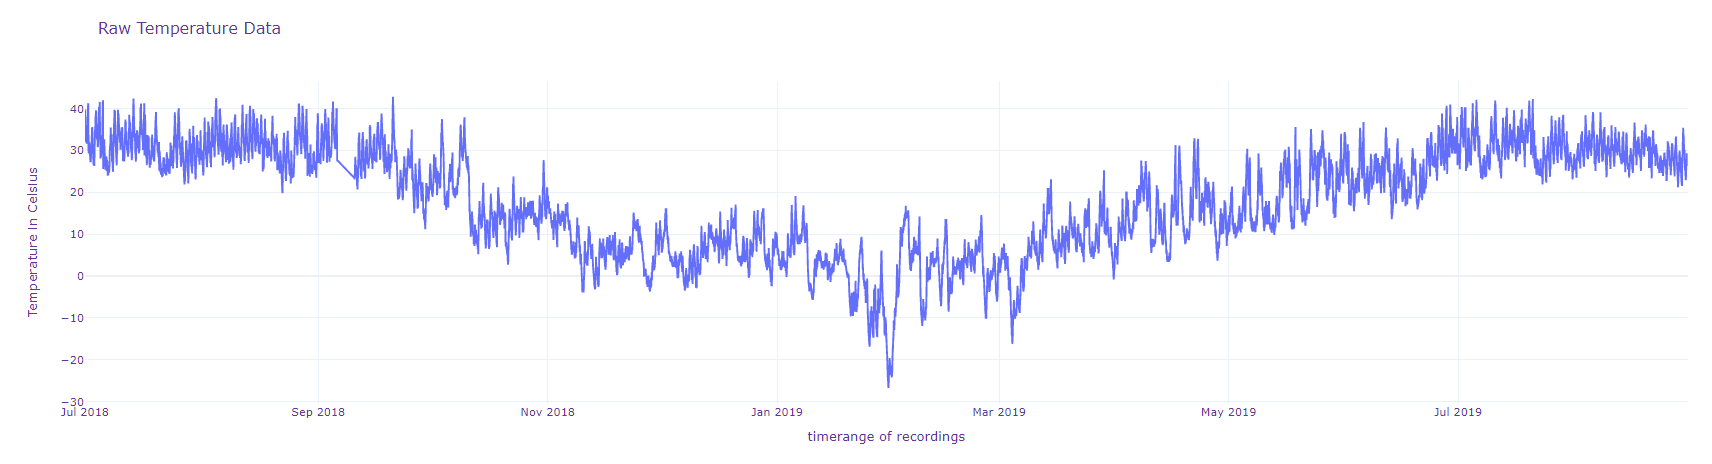

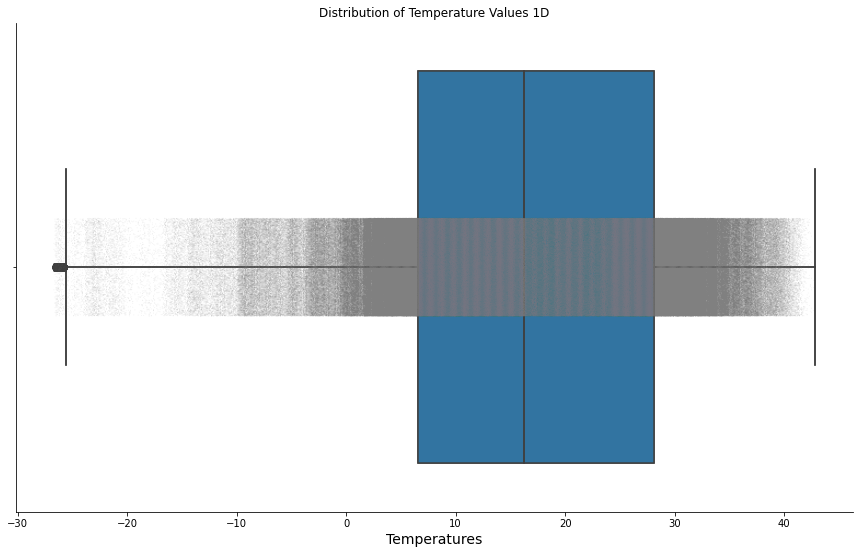

In [17]:
plt.figure(figsize=(15,9))
sns.boxplot(x=tdf.value_hrf)
boxplot = sns.boxplot(x=tdf.value_hrf, showfliers=True)
boxplot = sns.stripplot(x=tdf.value_hrf, 
                        marker="o",
                        size=1,
                        alpha=0.1, 
                        color="grey")
boxplot.axes.set_title("Distribution of Temperature Values 1D", fontsize=12)
boxplot.set_xlabel("Temperatures", fontsize=14)
boxplot.set_ylabel("", fontsize=14)
sns.despine()
plt.show(); 
# plt.savefig('D:\\GITHUB_Repos\\SensorAnalysis
# \\ENTER\\results\\histogram_isolation_forest.png', dpi=500)

In [18]:
tdf.head(10)

,value_hrf,T
timestamp,,
2018-07-01 00:00:10,39.3,2018-07-01 00:00:10
2018-07-01 00:00:35,39.4,2018-07-01 00:00:35
2018-07-01 00:01:00,39.6,2018-07-01 00:01:00
2018-07-01 00:01:25,39.5,2018-07-01 00:01:25
2018-07-01 00:01:50,39.5,2018-07-01 00:01:50
2018-07-01 00:02:15,39.4,2018-07-01 00:02:15
2018-07-01 00:02:40,39.4,2018-07-01 00:02:40
2018-07-01 00:03:06,39.3,2018-07-01 00:03:06
2018-07-01 00:03:31,39.4,2018-07-01 00:03:31


# K-means Clustering Attempt

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [20]:
type([tdf.value_hrf])

list

In [21]:
tdf.value_hrf.values.reshape(-1,1)[:10]

array([[39.3],
       [39.4],
       [39.6],
       [39.5],
       [39.5],
       [39.4],
       [39.4],
       [39.3],
       [39.4],
       [39.4]])

In [22]:
X = StandardScaler().fit_transform(tdf.value_hrf.values.reshape(-1,1))

In [23]:
type(X)

numpy.ndarray

In [24]:

kmeans_model = KMeans(n_clusters=4, 
                      n_jobs=-1, 
                      random_state=42,
                      verbose=1).fit(X)

# algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
#     n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
#     random_state=0, tol=0.0001, verbose=0)

print("kmeans_model:\n", kmeans_model)


Initialization complete
Iteration 0, inertia 153443.87448819945
Iteration 1, inertia 130314.0038821485
Iteration 2, inertia 127930.2949175336
Iteration 3, inertia 126534.904094061
Iteration 4, inertia 125625.14646741457
Iteration 5, inertia 124659.14660509546
Iteration 6, inertia 123924.9048165895
Iteration 7, inertia 123325.76860545235
Iteration 8, inertia 122888.83158325333
Iteration 9, inertia 122604.92358231841
Iteration 10, inertia 122326.5447713444
Iteration 11, inertia 122069.37238784927
Iteration 12, inertia 121937.26299533057
Iteration 13, inertia 121814.7169107878
Iteration 14, inertia 121699.3983674895
Iteration 15, inertia 121626.18778775076
Iteration 16, inertia 121539.58905552127
Iteration 17, inertia 121480.49507848504
Iteration 18, inertia 121413.11097392502
Converged at iteration 18: center shift 9.736828950943123e-05 within tolerance 9.999999999999994e-05.
Initialization complete
Iteration 0, inertia 162988.51527997074
Iteration 1, inertia 129133.50948545408
Iteration

In [25]:
centers = kmeans_model.cluster_centers_
centers

array([[ 1.06001096],
       [-0.87110589],
       [-0.011274  ],
       [-1.84132648]])

In [26]:
kmeans_model.n_iter_

24

In [27]:
kmeans_model.n_clusters

4

In [28]:
kmeans_model.cluster_centers_

array([[ 1.06001096],
       [-0.87110589],
       [-0.011274  ],
       [-1.84132648]])

In [29]:
kmeans_model

KMeans(n_clusters=4, n_jobs=-1, random_state=42, verbose=1)

In [30]:
# print('tom\ttom')

Plotting:

# Plotting the k-mean cluster centroid locations...

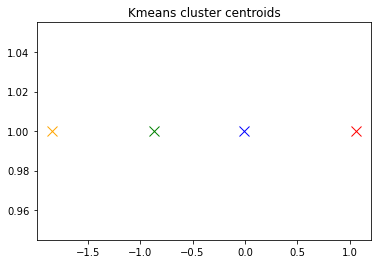

In [31]:

colors = ['r','g','b', 'orange']
centroids = kmeans_model.cluster_centers_
for n, y in enumerate(centroids):
    plt.plot(y, 1, marker='x', color=colors[n], ms=10)
plt.title('Kmeans cluster centroids'); 
# remember, these are standardscaler applied already 



---

In [32]:
kmeans_model.inertia_

121300.60813785985

In [33]:
len(kmeans_model.labels_)

1337728

In [34]:
len(tdf.value_hrf)

1337728

In [35]:

# adding label...
tdf['assigned_label'] = kmeans_model.labels_


In [36]:
tdf.tail(10)

,value_hrf,T,assigned_label
timestamp,,,
2019-07-30 23:56:06,28.5,2019-07-30 23:56:06,0
2019-07-30 23:56:31,28.6,2019-07-30 23:56:31,0
2019-07-30 23:56:56,28.6,2019-07-30 23:56:56,0
2019-07-30 23:57:21,28.4,2019-07-30 23:57:21,0
2019-07-30 23:57:46,28.4,2019-07-30 23:57:46,0
2019-07-30 23:58:11,28.5,2019-07-30 23:58:11,0
2019-07-30 23:58:37,28.5,2019-07-30 23:58:37,0
2019-07-30 23:59:02,28.6,2019-07-30 23:59:02,0
2019-07-30 23:59:27,28.5,2019-07-30 23:59:27,0


In [37]:
tdf.assigned_label.value_counts()

0    508598
1    405292
2    325727
3     98111
Name: assigned_label, dtype: int64

# Plotting the points by the k-mean cluster (4) determined:

##  Cluster: 0 

In [38]:
# HUGE OUTPUT:

# fig = go.Figure(data=[go.Scatter(x=tdf[tdf.assigned_label==0].index,  
#                                  y=tdf[tdf.assigned_label==0].value_hrf)])
                           
# fig = fig.update_layout(
#     title="K-Means Cluster: 0",
#     xaxis_title="Roughly Summer Months",
#     yaxis_title="Temperature in Celsius",
#     template = 'plotly_white', 
#     font=dict(size=12,color="red"))

# fig = fig.update_traces(marker=dict(size=1, color='red', 
#                                line=dict(width=1,
#                                         color='DarkSlateGrey')),
#                   selector=dict(mode='markers'))

# iplot(fig)

# --- if you want to export the plot to html for further study ---
# this code works for exporting:
# fig.write_html("D:\\GITHUB_Repos\\SensorAnalysis\\ENTER\\results\\iso_forest_base_data_plotted.html")


# EXCLUSIVELY ONLY DATAPOINTS IN THE 'SUMMER' !!!!!!!!!!

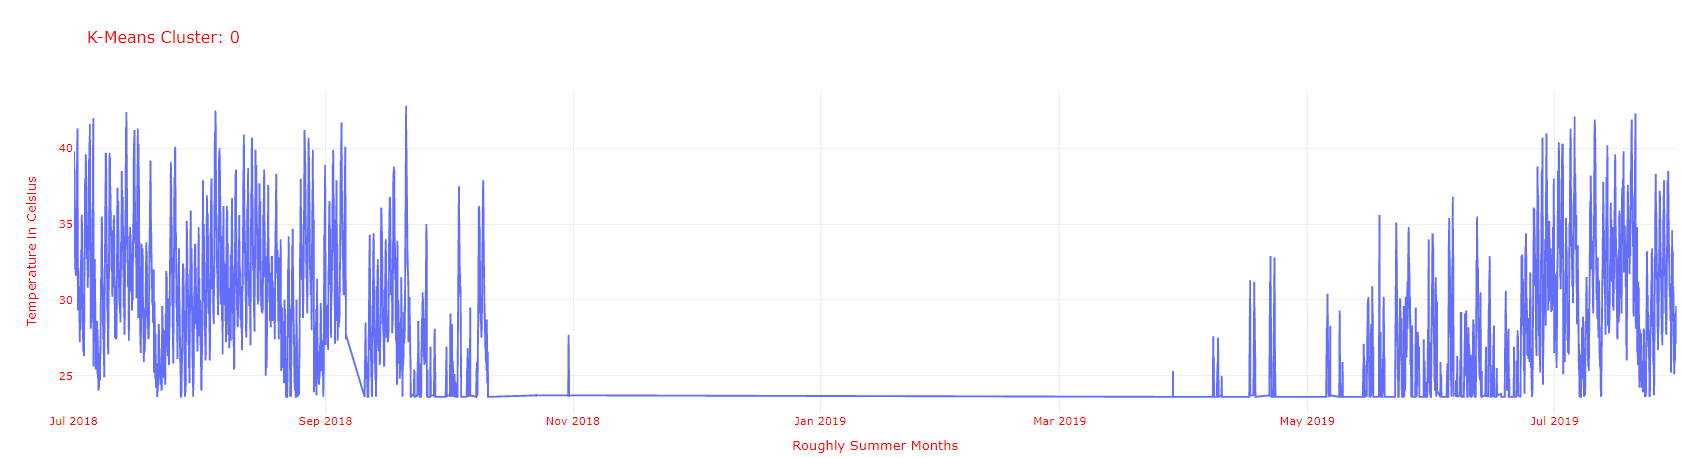

## Cluster: 1

In [39]:
# HUGE OUTPUT:

# fig = go.Figure(data=[go.Scatter(x=tdf[tdf.assigned_label==1].index,  
#                                  y=tdf[tdf.assigned_label==1].value_hrf)])
                           
# fig = fig.update_layout(
#     title="K-Means Cluster: 1",
#     xaxis_title="Roughly Generalized Winter Months",
#     yaxis_title="Temperature in Celsius",
#     template = 'plotly_white', 
#     font=dict(size=12,color="green"))

# fig = fig.update_traces(marker=dict(size=1, color='red', 
#                                line=dict(width=1,
#                                         color='DarkSlateGrey')),
#                   selector=dict(mode='markers'))

# iplot(fig)

# --- if you want to export the plot to html for further study ---
# this code works for exporting:
# fig.write_html("D:\\GITHUB_Repos\\SensorAnalysis\\ENTER\\results\\iso_forest_base_data_plotted.html")


# EXCLUSIVELY ONLY DATAPOINTS IN THE 'SUMMER' !!!!!!!!!!

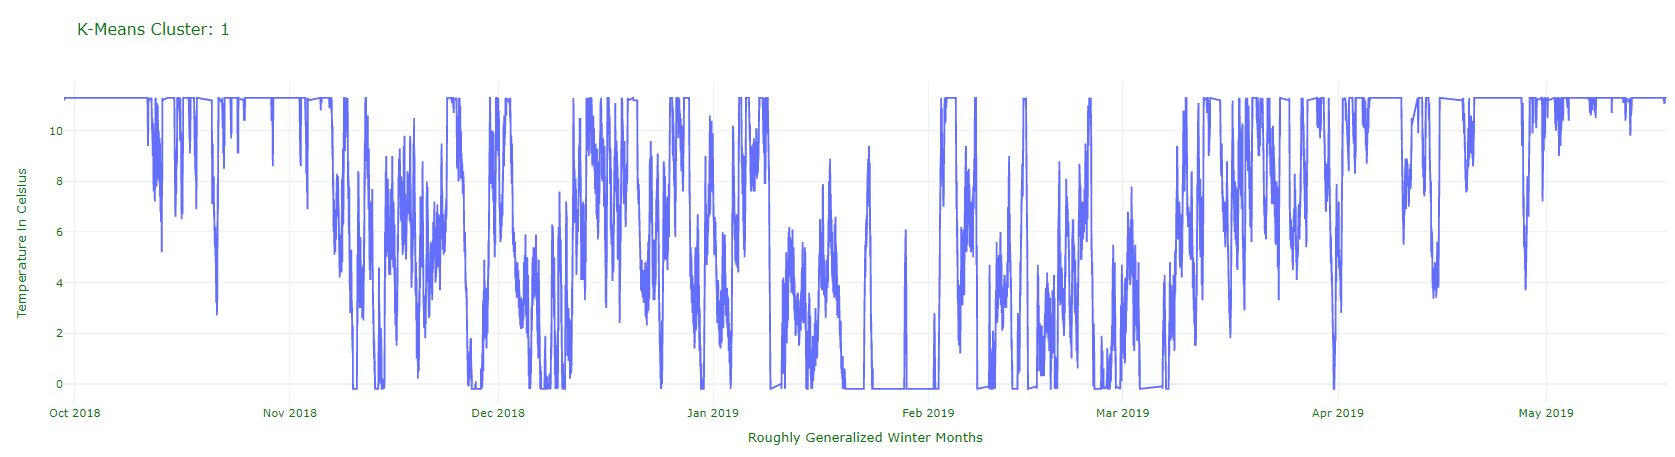

##  Cluster: 2 

In [40]:
# HUGE OUTPUT:

# fig = go.Figure(data=[go.Scatter(x=tdf[tdf.assigned_label==2].index,  
#                                  y=tdf[tdf.assigned_label==2].value_hrf)])
               
# fig = fig.update_layout(
#     title="K-Means Cluster: 2",
#     xaxis_title="Warmer Temperatures in parts of Fall and Later Spring Months",
#     yaxis_title="Temperature in Celsius",
#     template = 'plotly_white', 
#     font=dict(size=12,color="blue"))

# fig = fig.update_traces(marker=dict(size=1, color='red', 
#                                line=dict(width=1,
#                                         color='DarkSlateGrey')),
#                   selector=dict(mode='markers'))

# iplot(fig)

# --- if you want to export the plot to html for further study ---
# this code works for exporting:
# fig.write_html("D:\\GITHUB_Repos\\SensorAnalysis\\ENTER\\results\\iso_forest_base_data_plotted.html")


# EXCLUSIVELY ONLY DATAPOINTS IN THE 'SUMMER' !!!!!!!!!!

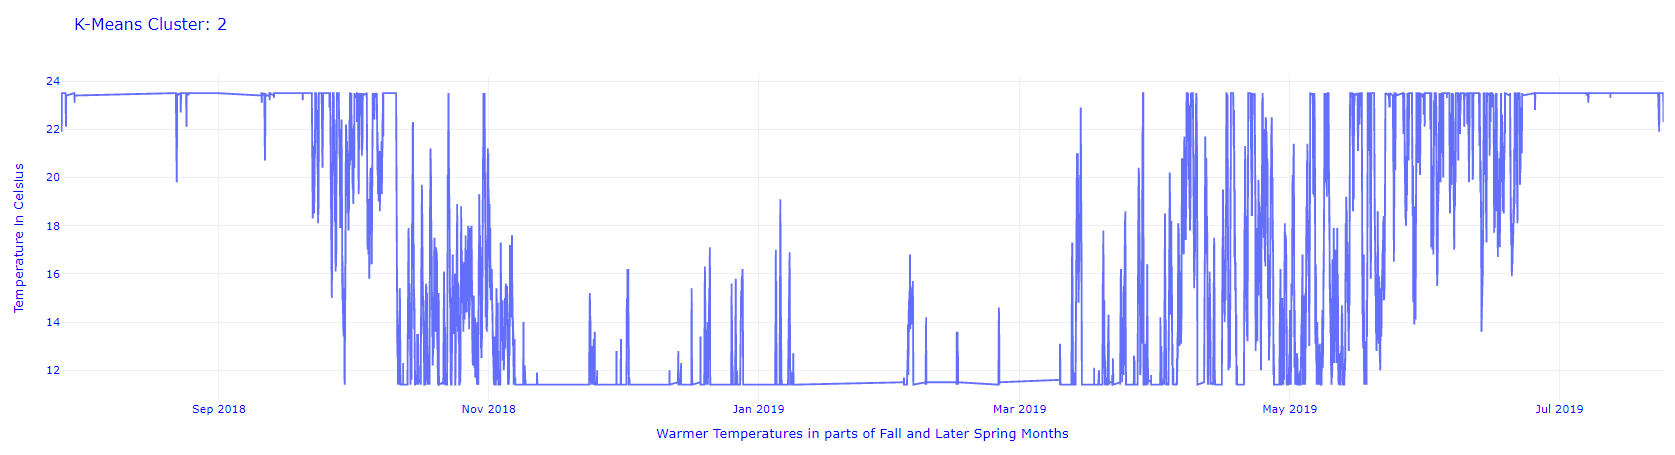

## Cluster: 3

In [41]:
# HUGE OUTPUT:

# fig = go.Figure(data=[go.Scatter(x=tdf[tdf.assigned_label==3].index,  
#                                  y=tdf[tdf.assigned_label==3].value_hrf)])
               
# fig = fig.update_layout(
#     title="K-Means Cluster: 3",
#     xaxis_title="Very Very Cold Region (Polar Vortex) Months",
#     yaxis_title="Temperature in Celsius",
#     template = 'plotly_white', 
#     font=dict(size=12,color="orange"))

# fig = fig.update_traces(marker=dict(size=1, color='red', 
#                                line=dict(width=1,
#                                         color='DarkSlateGrey')),
#                   selector=dict(mode='markers'))

# iplot(fig)

# --- if you want to export the plot to html for further study ---
# this code works for exporting:
# fig.write_html("D:\\GITHUB_Repos\\SensorAnalysis\\ENTER\\results\\iso_forest_base_data_plotted.html")


# EXCLUSIVELY ONLY DATAPOINTS IN THE 'SUMMER' !!!!!!!!!!

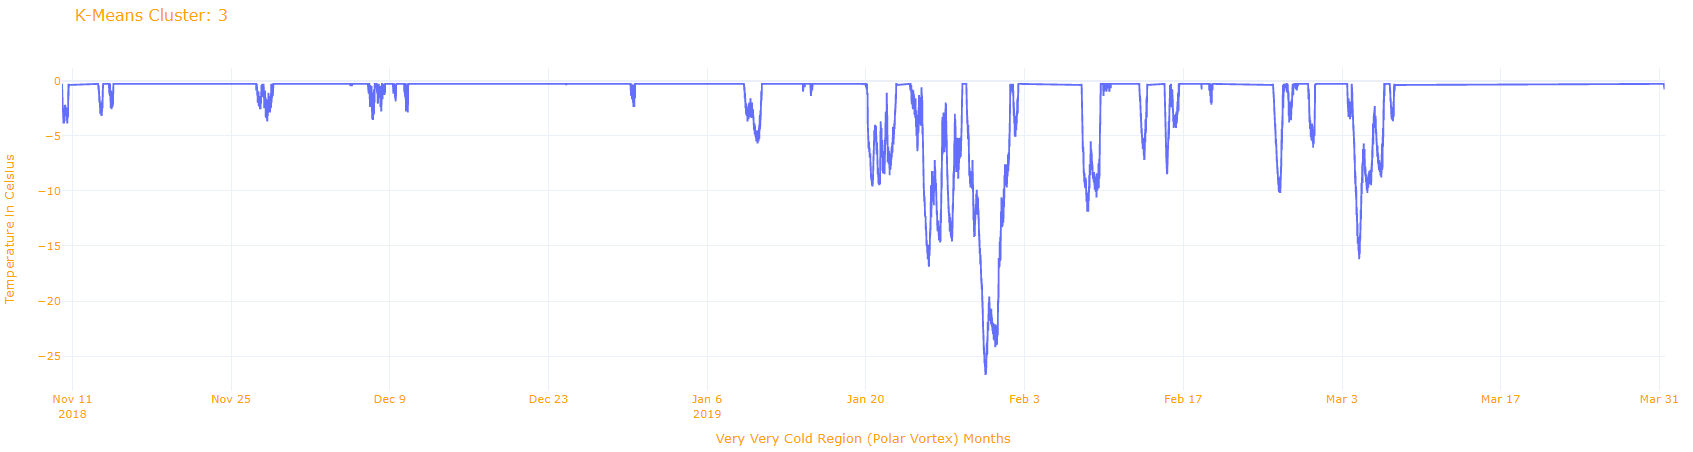

In [42]:
# THIS WORKS BUT HAS HUGE HUGE OUTPUT:


# --- PLOTS ALL OF THE DATA AND IDENTIFIED ANOMALIES IN PLOTLY, FULLY INTERACTIVE ---
# uncomment out if you want to see it...


# fig = go.Figure(data=[original_data, anomalies_red], layout=layout)

# fig = fig.update_layout(title="Anomalies determined with Isolation Forest - Single Sensor - Chicago Region", 
#                        template="plotly_dark", 
#                        yaxis_title='Temperature in Celsius')
# LAUNCHES:
# iplot(fig)

# SAVING / EXPORTING: 
# works:  iplot(fig, image='svg', filename='D:\\GITHUB_Repos\\SensorAnalysis\\ENTER\\results\\iso_forest_final_AD_plotted_2.svg')


# interesting:  this seems to export just fine but sometimes you have to do it twice:
# fig.write_html("D:\\GITHUB_Repos\\SensorAnalysis\\ENTER\\results\\isolation_forest_final_AD_plotted_superhighres.html")


# fig.write_image("D:\\GITHUB_Repos\\SensorAnalysis\\ENTER\\results\\isol_forest_final_AD_plotted.svg")
# plt.savefig('D:\\GITHUB_Repos\\SensorAnalysis\\ENTER\\results\\histogram_anomaly_scores_isolation_forest.png', dpi=800)
# fig.write_html("isolation_forest_working_high_resolution.html")

